# Random Forest

In [8]:
import sys
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier

In [9]:
sys.path.append(os.path.abspath("../funciones"))

from funcionesEntrenamiento import (
    cargar_datos_entrenamiento,
    cargar_datos_prueba,
    imprimir_forma,
    division_train_val,
    reporte_clasificacion,
    crear_matriz_confusion,
    calcular_roc_auc,
    metricas_tpr_fpr,
    hacer_pepinillo
)

In [10]:
X, y = cargar_datos_entrenamiento()

shape, head = imprimir_forma(X)
print("Shape: ", shape)
head

Shape:  (1500, 1368)


,longitud_texto,num_palabras,comida,restriccion,purga,imagen_corporal,ejercicio,polaridad,subjetividad,tag_Anorexia,...,tfidf_1290,tfidf_1291,tfidf_1292,tfidf_1293,tfidf_1294,tfidf_1295,tfidf_1296,tfidf_1297,tfidf_1298,tfidf_1299
0,0.242191,-0.059671,0,0,0,0,0,1.173738,0.353420,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-1.549985,-1.624910,0,0,0,0,0,-0.336367,-1.128151,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.456454,-0.283276,3,2,0,0,0,0.796212,0.946048,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.333319,0.163935,0,0,0,1,0,1.777780,0.649734,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.790588,-0.730488,0,0,0,1,0,-1.317935,0.946048,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
X_train, X_val, y_train, y_val = division_train_val(X, y)

train_shape, _ = imprimir_forma(X_train)
val_shape, _ = imprimir_forma(X_val)
print(f"Forma de conjunto de entrenamiento:", train_shape)
print(f"Forma de conjunto de validación:", val_shape)

Forma de conjunto de entrenamiento: (1200, 1368)
Forma de conjunto de validación: (300, 1368)


## Entrenamiento inicial de Random Forest

In [12]:
rf_inicial = RandomForestClassifier(random_state=22)

scores = cross_val_score(rf_inicial, X_train, y_train, cv=5, scoring='roc_auc')

print("Resultados por fold:", scores)
print("Precisión promedio:", scores.mean())

Resultados por fold: [0.90935121 0.92248062 0.90121517 0.90178571 0.95204381]
Precisión promedio: 0.9173753041156294


In [13]:
rf_inicial.fit(X_train, y_train)

RandomForestClassifier(random_state=22)

In [14]:
y_pred_inicial, y_proba_inicial, reporte_inicial = reporte_clasificacion(X_val, y_val, rf_inicial)

print("Classification Report:")
print(reporte_inicial)

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.77      0.84       139
           1       0.83      0.94      0.88       161

    accuracy                           0.86       300
   macro avg       0.87      0.85      0.86       300
weighted avg       0.87      0.86      0.86       300



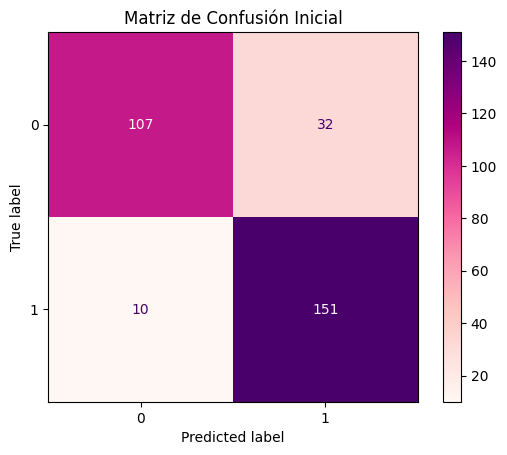

In [15]:
cm_inicial, disp_inicial = crear_matriz_confusion(y_val, y_pred_inicial)
disp_inicial.plot(cmap='RdPu')
plt.title("Matriz de Confusión Inicial")
plt.show()

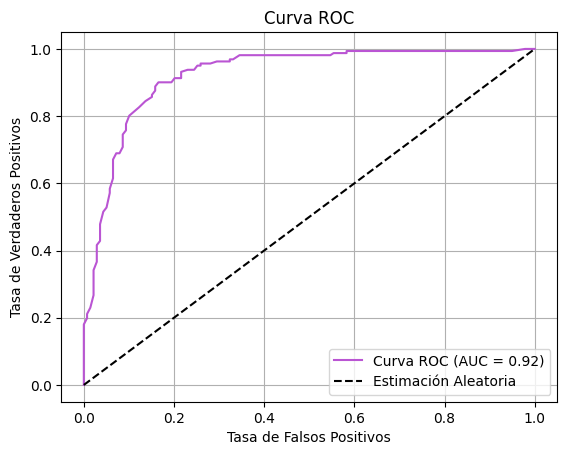

In [16]:
fpr_inicial, tpr_inicial, thresholds_inicial, auc_score_inicial = calcular_roc_auc(y_val, y_proba_inicial)

plt.figure()
plt.plot(fpr_inicial, tpr_inicial, color='mediumorchid', label=f"Curva ROC (AUC = {auc_score_inicial:.2f})")
plt.plot([0, 1], [0, 1], 'k--', label="Estimación Aleatoria")
plt.xlabel("Tasa de Falsos Positivos")
plt.ylabel("Tasa de Verdaderos Positivos")
plt.title("Curva ROC")
plt.legend(loc="lower right")
plt.grid()
plt.show()

In [17]:
TPR_inicial, FPR_inicial = metricas_tpr_fpr(cm_inicial)

# Mostrar métricas
print(f"AUC: {(auc_score_inicial * 100):.4f}")
print(f"TPR (Tasa de Positivos Verdaderos): {(TPR_inicial * 100):.4f}")
print(f"FPR (Tasa de Falsos Positivos): {(FPR_inicial * 100):.4f}")

AUC: 92.3790
TPR (Tasa de Positivos Verdaderos): 93.7888
FPR (Tasa de Falsos Positivos): 23.0216


## Búsqueda de mejores parámetros (Entrenamiento y Validación)

In [21]:
rf = RandomForestClassifier(random_state=22)

param_grid = {
    'n_estimators': [500, 550, 600, 650, 700],
    'max_depth': [None, 2, 4, 6, 8, 10],
    'min_samples_split': [4, 5, 6, 7, 8],
    'max_features': ['sqrt', 'log2', None],
    'min_samples_leaf': [1, 2, 3, 4, 5],
    'criterion': ['gini', 'entropy', 'log_loss']
}

cv = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=22
)

grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=cv,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1,
    error_score='raise'
)

In [22]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=22, shuffle=True),
             error_score='raise',
             estimator=RandomForestClassifier(random_state=22), n_jobs=-1,
             param_grid={'criterion': ['entropy'], 'max_depth': [None],
                         'max_features': ['log2'], 'min_samples_leaf': [1],
                         'min_samples_split': [6], 'n_estimators': [600]},
             scoring='roc_auc', verbose=1)

In [7]:
grid_search.best_params_

{'criterion': 'entropy',
 'max_depth': None,
 'max_features': 'log2',
 'min_samples_leaf': 1,
 'min_samples_split': 6,
 'n_estimators': 600}

In [8]:
best_randomforest = RandomForestClassifier(
    n_estimators = 600,
    criterion = 'entropy',
    max_depth = None,
    max_features = 'log2',
    min_samples_leaf = 1,
    min_samples_split = 6,
    random_state = 22
)

best_randomforest.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', max_features='log2',
                       min_samples_split=6, n_estimators=600, random_state=22)

In [9]:
y_pred, y_proba, reporte = reporte_clasificacion(X_val, y_val, best_randomforest)

print("Classification Report:")
print(reporte)

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.79      0.85       139
           1       0.84      0.94      0.89       161

    accuracy                           0.87       300
   macro avg       0.88      0.86      0.87       300
weighted avg       0.87      0.87      0.87       300



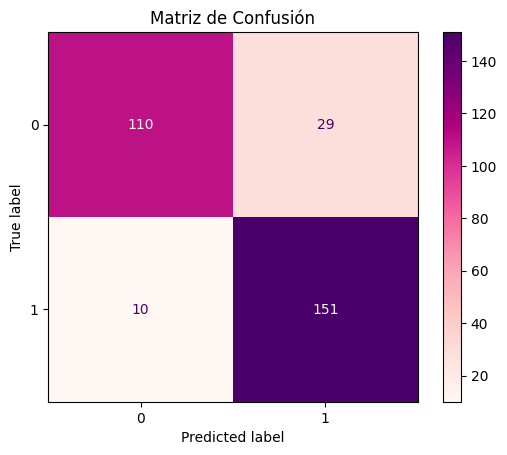

In [10]:
cm, disp = crear_matriz_confusion(y_val, y_pred)
disp.plot(cmap='RdPu')
plt.title("Matriz de Confusión")
plt.show()

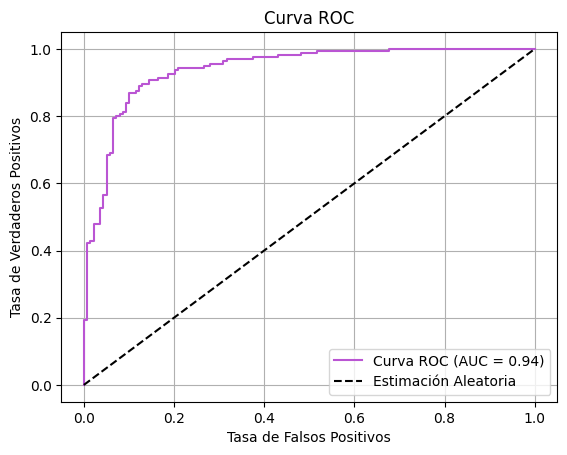

In [11]:
fpr, tpr, thresholds, auc_score = calcular_roc_auc(y_val, y_proba)

plt.figure()
plt.plot(fpr, tpr, color='mediumorchid', label=f"Curva ROC (AUC = {auc_score:.2f})")
plt.plot([0, 1], [0, 1], 'k--', label="Estimación Aleatoria")
plt.xlabel("Tasa de Falsos Positivos")
plt.ylabel("Tasa de Verdaderos Positivos")
plt.title("Curva ROC")
plt.legend(loc="lower right")
plt.grid()
plt.show()

In [12]:
TPR, FPR = metricas_tpr_fpr(cm)

# Mostrar métricas
print(f"AUC: {(auc_score * 100):.4f}")
print(f"TPR (Tasa de Positivos Verdaderos): {(TPR * 100):.4f}")
print(f"FPR (Tasa de Falsos Positivos): {(FPR * 100):.4f}")

AUC: 93.9050
TPR (Tasa de Positivos Verdaderos): 93.7888
FPR (Tasa de Falsos Positivos): 20.8633


## Modelo Final (Entrenamiento y Prueba)

In [13]:
modelRF = RandomForestClassifier(
    n_estimators = 600,
    criterion = 'entropy',
    max_depth = None,
    max_features = 'log2',
    min_samples_leaf = 1,
    min_samples_split = 6,
    random_state = 22
)

modelRF.fit(X, y)

RandomForestClassifier(criterion='entropy', max_features='log2',
                       min_samples_split=6, n_estimators=600, random_state=22)

In [14]:
X_test, y_test = cargar_datos_prueba()

shape_test, head_test = imprimir_forma(X_test)
print("Shape test: ", shape_test)
head_test

Shape test:  (250, 1368)


,longitud_texto,num_palabras,comida,restriccion,purga,imagen_corporal,ejercicio,polaridad,subjetividad,tag_Anorexia,...,tfidf_1290,tfidf_1291,tfidf_1292,tfidf_1293,tfidf_1294,tfidf_1295,tfidf_1296,tfidf_1297,tfidf_1298,tfidf_1299
0,-0.395702,-0.506882,0,1,0,0,0,0.972391,1.341134,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2.338126,2.399991,0,1,0,1,1,-0.185357,0.538616,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.881716,-0.730488,2,2,0,0,0,-0.336367,-1.128151,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.181439,-0.283276,1,3,0,1,0,-0.336367,-1.128151,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2.338126,3.294413,1,3,0,0,0,-0.336367,-1.128151,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
y_pred_test, y_proba_test, reporte_test = reporte_clasificacion(X_test, y_test, modelRF)

print("Classification Report:")
print(reporte_test)

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.75      0.82       116
           1       0.81      0.93      0.86       134

    accuracy                           0.84       250
   macro avg       0.85      0.84      0.84       250
weighted avg       0.85      0.84      0.84       250



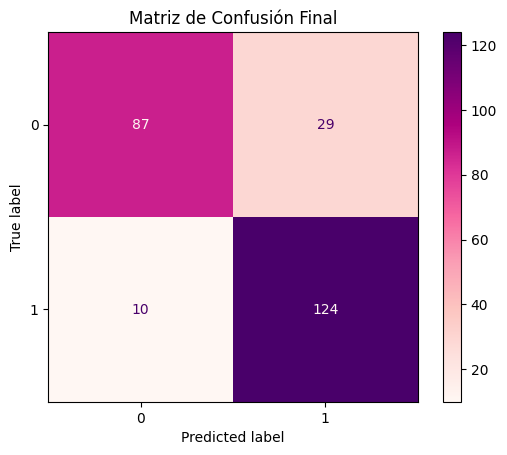

In [16]:
cm_test, disp_test = crear_matriz_confusion(y_test, y_pred_test)
disp_test.plot(cmap='RdPu')
plt.title("Matriz de Confusión Final")
plt.show()

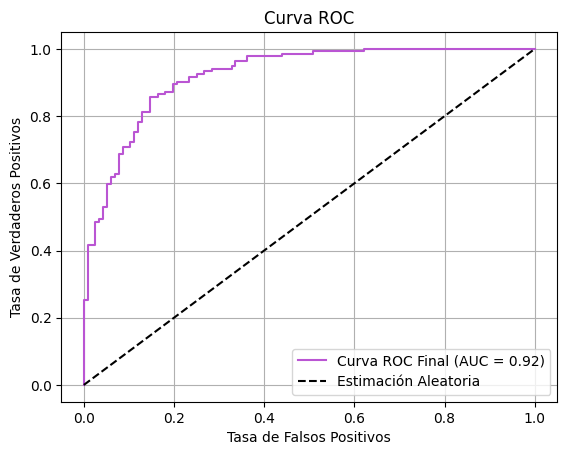

In [17]:
fpr_test, tpr_test, thresholds_test, auc_score_test = calcular_roc_auc(y_test, y_proba_test)

plt.figure()
plt.plot(fpr_test, tpr_test, color='mediumorchid', label=f"Curva ROC Final (AUC = {auc_score_test:.2f})")
plt.plot([0, 1], [0, 1], 'k--', label="Estimación Aleatoria")
plt.xlabel("Tasa de Falsos Positivos")
plt.ylabel("Tasa de Verdaderos Positivos")
plt.title("Curva ROC")
plt.legend(loc="lower right")
plt.grid()
plt.show()

In [18]:
TPR_test, FPR_test = metricas_tpr_fpr(cm_test)

# Mostrar métricas
print(f"AUC: {(auc_score_test * 100):.4f}")
print(f"TPR (True Positive Rate): {(TPR_test * 100):.4f}")
print(f"FPR (False Positive Rate): {(FPR_test * 100):.4f}")

AUC: 92.1577
TPR (True Positive Rate): 92.5373
FPR (False Positive Rate): 25.0000


In [19]:
hacer_pepinillo(modelRF, "modelRF.pkl")